In [1]:
import tensorflow as tf
# import plotly.express as px
import matplotlib.pyplot as plt
from utils import *
import pandas as pd

In [2]:
directory = 'images/final/'
width = 96
height = 96
channels = 4
image_size = (width, height)
input_shape = (width, height, channels)
batch_size = 32
latent_dim = 100

In [3]:
train_ds, class_names = load_data(directory, batch_size, image_size, GAN=True)

Found 13849 files belonging to 905 classes.


In [4]:
types = pd.read_csv('PokeDataset.csv', usecols=['Name', 'Type1', 'Type2'])
# reorder by alphabetical order of column 'Name'
types = types.sort_values(by=['Name'])
types = types.reset_index(drop=True)

In [5]:
# give percentage of pokemon with double type
print(f"Percentage of pokemon with double type: {types['Type2'].count() / types['Type1'].count() * 100:.2f}%")

Percentage of pokemon with double type: 50.69%


In [6]:
types.head(5)

,Name,Type1,Type2
0,Abomasnow,Grass,Ice
1,Abra,Psychic,NaN
2,Absol,Dark,NaN
3,Accelgor,Bug,NaN
4,Aegislash,Steel,Ghost


In [7]:
# make a dictionary of types and their index in the list of types
types_dict = {}
for i, t in enumerate(types['Type1'].unique()):
    types_dict[t] = i

# create vector of labels with 0 for each type except the one in the row (type1 and type2 are strings)
def create_label(row):
    label = np.zeros(18)
    label[types_dict[row['Type1']]] = 1
    if row['Type2'] in types_dict:
        label[types_dict[row['Type2']]] = 1
    return label

types['Label'] = types.apply(create_label, axis=1)

In [8]:
def types_to_vector(type1, type2=None):
    label = np.zeros(18)
    label[types_dict[type1]] = 1
    if type2 in types_dict:
        label[types_dict[type2]] = 1
    return label.reshape(1, 18)

In [9]:
for x, y in train_ds.take(1):
    print(int(tf.argmax(tf.reshape(y[0], [-1, 1]), axis=0)))
    plot_image(x[0], class_names[int(tf.argmax(tf.reshape(y[0], [-1, 1]), axis=0))], size=width)

521


In [10]:
# map labels in train_ds to the column Label in types
def map_labels(x, y):
    y_onehot = tf.argmax(y, axis=1).numpy()
    y_labels = np.zeros((len(y_onehot), 18))
    for i in range(len(y_onehot)):
        y_labels[i] = types.loc[y_onehot[i], 'Label']
    y_label = np.insert(y_labels, 0, 1, axis=1)
    y_label_tensor = tf.convert_to_tensor(y_label, dtype=tf.float32)
    return x, y_label_tensor



In [11]:
train_ds = prepare(train_ds, shuffle=True, augment=True, GAN=True)
train_ds = train_ds.map(lambda x, y: tf.py_function(map_labels, [x, y], [tf.float32, tf.float32]))

channels = 3
input_shape = (width, height, channels)

In [22]:
plot_n_images(train_ds, 5, class_names, GAN=True, size=width)

In [114]:
from keras.layers import Input, Dense, Conv2D, Flatten, Lambda, Reshape, BatchNormalization, Concatenate, LeakyReLU, Dropout, Activation, UpSampling2D
from keras.models import Model
from keras import backend as K
import numpy as np


def build_encoder(input_shape, latent_dim):
    # Define the input shape
    input_shape = (96, 96, 3)

    # Define the number of latent variables
    latent_dim = 100

    # Define the encoder architecture
    input_encoder = Input(shape=input_shape, name='input_encoder')
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(input_encoder)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    
    # Define sampling function
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    # Sample the latent space
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
    # Define the encoder
    encoder = Model(input_encoder, [z_mean, z_log_var, z], name='encoder')

    return encoder


# Define the generator
def build_decoder(latent_dim):
    # Define the noise vector input
    in_lat = tf.keras.layers.Input(shape=(latent_dim,))
    # Define the class vector input
    # in_class = tf.keras.layers.Input(shape=(num_classes,))
    # Concatenate the noise and class vectors
    # merge = tf.keras.layers.Concatenate()([in_lat, in_class])
    # Project the concatenated vector to a larger dimension
    n = 128
    size = int(width/16)
    n_nodes = n * size * size
    dense = tf.keras.layers.Dense(n_nodes)(in_lat)
    # Reshape the dense layer output
    reshaped = tf.keras.layers.Reshape((size, size, n))(dense)
    # Upsample the feature maps
    upsampled = tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(reshaped)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    upsampled = tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(upsampled)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    upsampled = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(upsampled)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    upsampled = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(upsampled)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    # Output layer
    out_layer = tf.keras.layers.Conv2D(3, (3,3), activation='tanh', padding='same')(upsampled)
    # Define the model
    model = tf.keras.models.Model(in_lat, out_layer, name='decoder')

    return model

In [115]:
def build_discriminator(input_shape, latent_dim):
    # Define input layers
    img_input = Input(shape=input_shape)
    enc_input = Input(shape=(latent_dim,))

    # image branch
    img_layer = Conv2D(64, (3,3), strides=(2,2), padding='same')(img_input)
    img_layer = LeakyReLU(alpha=0.2)(img_layer)
    img_layer = Dropout(0.25)(img_layer)
    img_layer = Conv2D(128, (3,3), strides=(2,2), padding='same')(img_layer)
    img_layer = LeakyReLU(alpha=0.2)(img_layer)
    img_layer = Dropout(0.25)(img_layer)
    img_layer = Conv2D(256, (3,3), strides=(2,2), padding='same')(img_layer)
    img_layer = LeakyReLU(alpha=0.2)(img_layer)
    img_layer = Dropout(0.25)(img_layer)
    img_layer = Conv2D(512, (3,3), strides=(2,2), padding='same')(img_layer)
    img_layer = LeakyReLU(alpha=0.2)(img_layer)
    img_layer = Dropout(0.25)(img_layer)
    # Flatten the features
    features = Flatten()(img_layer)

    # label branch
    latent_layer = tf.keras.layers.Dense(64)(enc_input)
    latent_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(latent_layer)
    latent_layer = tf.keras.layers.Dense(128)(latent_layer)
    latent_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(latent_layer)
    latent_layer = tf.keras.layers.Dense(256)(latent_layer)
    latent_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(latent_layer)
    latent_layer = tf.keras.layers.Dense(256)(latent_layer)
    latent_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(latent_layer)
    latent_layer = tf.keras.layers.Flatten()(latent_layer)

    # Concatenate the input layers
    merged_input = Concatenate()([features, latent_layer])
    merged_input = tf.keras.layers.Dropout(0.4)(merged_input)
    validity = Dense(1, activation='sigmoid')(merged_input)

    # Define the model
    model = Model(inputs=[img_input, enc_input], outputs=validity, name='discriminator')

    # compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model


In [116]:
decoder = build_decoder(latent_dim)
encoder = build_encoder(input_shape, latent_dim)
discriminator = build_discriminator(input_shape, latent_dim)

In [100]:
def build_vae(encoder, decoder, input_shape, latent_dim):
    # Define the input layer
    in_layer = tf.keras.layers.Input(shape=input_shape)
    # Connect the input layer to the encoder
    encoded_latent = encoder(in_layer)
    # Connect the latent vector to the decoder
    gen_output = decoder(encoded_latent)
    # Define the VAE model
    vae_model = tf.keras.models.Model(in_layer, gen_output, name='vae')
    # Compile the VAE model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    vae_model.compile(loss='mse', optimizer=opt)
    return vae_model

def build_gan(decoder, discriminator, input_shape, latent_dim):
    # Define the input layer
    in_layer = tf.keras.layers.Input(shape=latent_dim)
    # Connect the input layer to the encoder
    # encoded_latent = encoder(in_layer)
    # Connect the latent vector to the decoder
    gen_output = decoder(in_layer)
    # Freeze the discriminator weights during generator training
    discriminator.trainable = False
    # Connect the generated image to the discriminator
    gan_output = discriminator([gen_output, in_layer])
    # Define the GAN model
    gan_model = tf.keras.models.Model(in_layer, gan_output, name='gan')
    # Compile the GAN model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    gan_model.compile(loss='binary_crossentropy', optimizer=opt)
    return gan_model


In [101]:
# vae = build_vae(encoder, decoder, input_shape, latent_dim)
# gan = build_gan(decoder, discriminator, input_shape, latent_dim)

In [102]:

# def build_vaegan(encoder, decoder, discriminator, input_shape, latent_dim):
#     # Define the input layer
#     in_layer = tf.keras.layers.Input(shape=input_shape)
#     # Connect the input layer to the encoder
#     encoded_latent = encoder(in_layer)
#     # Connect the latent vector to the decoder
#     gen_output = decoder(encoded_latent)
#     # Freeze the discriminator weights during generator training
#     discriminator.trainable = False
#     # Connect the generated image to the discriminator
#     gan_output = discriminator([gen_output, encoded_latent])
#     # Define the VAE-GAN model
#     vaegan_model = tf.keras.models.Model(in_layer, gan_output, name='vaegan')
#     # Compile the VAE-GAN model
#     opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
#     vaegan_model.compile(loss='binary_crossentropy', optimizer=opt)
#     return vaegan_model


In [145]:
def build_vaegan(input_shape, latent_dim):
    # Define the encoder and decoder
    encoder = build_encoder(input_shape, latent_dim)
    decoder = build_decoder(latent_dim)

    # Define the discriminator
    discriminator = build_discriminator(input_shape, latent_dim)

    # Define the generator
    in_shape = tf.keras.layers.Input(shape=input_shape)
    encoded_latent = encoder(in_shape)
    gen_output = decoder(encoded_latent)

    # Freeze the weights of the encoder and decoder
    encoder.trainable = False
    decoder.trainable = False

    # Define the GAN model
    gan_output = discriminator([gen_output, encoded_latent])
    gan_model = tf.keras.models.Model(in_shape, gan_output, name='gan')

    # Compile the GAN model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    gan_model.compile(loss='binary_crossentropy', optimizer=opt, experimental_run_tf_function=False)

    # Define the VAE-GAN model
    z_mean, z_log_var, z = encoder(in_shape)
    x_pred = decoder(z)
    vae_output = discriminator([x_pred, z])
    vae_model = tf.keras.models.Model(in_shape, [x_pred, vae_output], name='vae_gan')

    # Define the VAE loss function
    def vae_loss(y_true, y_pred):
        reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
        kl_loss = - 0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        return reconstruction_loss + 0.1 * kl_loss

    # Define the training step function
    @tf.function
    def train_step(x):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(x)
            x_pred = decoder(z)
            vae_loss_value = vae_loss(x, x_pred)
        vae_grads = tape.gradient(vae_loss_value, vae_model.trainable_variables)
        opt.apply_gradients(zip(vae_grads, vae_model.trainable_variables))
        return {'vae_loss': vae_loss_value}

    # Compile the VAE-GAN model
    vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss=vae_loss)

    return decoder, discriminator, gan_model, encoder, vae_model, train_step


# Train the VAE-GAN
decoder, discriminator, gan_model, encoder, vae_model, train_step = build_vaegan(input_shape=(96,96,3), latent_dim=100)
    

In [146]:
vae_model.loss

<function __main__.build_vaegan.<locals>.vae_loss(y_true, y_pred)>

In [147]:
for i, batch in enumerate(train_ds):
    x_batch = batch[0]
    # y_batch = decoder.predict(encoder.predict(x_batch, verbose=0)[-1], verbose=0)
    # plot first image with original and generated
    # plt.subplot(1, 2, 1)
    # plt.imshow(x_batch[0])
    # plt.subplot(1, 2, 2)
    # plt.imshow(y_batch[0])
    # plt.show()
    vae_model.fit(x_batch, x_batch)
    break

TypeError: in user code:

    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 282, in __call__
        metric_obj.update_state(
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\metrics\base_metric.py", line 486, in update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\keras_tensor.py", line 283, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_19'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


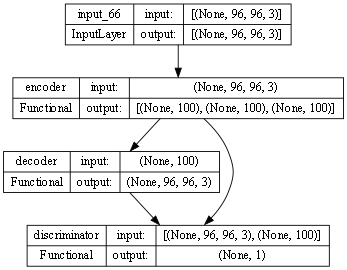

In [104]:
tf.keras.utils.plot_model(vae_model, to_file="vae.png", show_shapes=True, dpi=64)
tf.keras.utils.plot_model(gan_model, to_file="gan.png", show_shapes=True, dpi=64)


In [105]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = tf.random.normal(shape=(n_samples, latent_dim))
    return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    noise_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(noise_input, verbose=0)
    # create 'fake' class labels (0)
    y_class = tf.zeros((n_samples, 1))
    return X, y_class, noise_input

def generate_real_samples(dataset, encoder, n_samples):
    X, y_class = [], []
    while len(X) < n_samples:
        dataset.shuffle(100)
        for x, label in dataset.take(5):
            for i in range(len(x)):
                X.append(x[i])
                y_class.append(label[i][0])
                if len(X) == n_samples:
                    break
            if len(X) == n_samples:
                break
    X = tf.stack(X)
    y_class = tf.reshape(tf.stack(y_class), (n_samples, 1))
    # generate points in latent space using encoder
    encoded = encoder.predict(X, verbose=0)
    return X, y_class, encoded


In [106]:
def summarize_performance(epoch, g_model, d_model, encoder, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real_class, encoded = generate_real_samples(dataset, encoder, n_samples)
    # evaluate discriminator on real examples
    # print(X_real.shape)
    # print(encoded.shape)
    # print(y_real_class.shape)
    X_reconstructed = g_model.predict(encoded, verbose=0)
    _, acc_real = d_model.evaluate([X_reconstructed, encoded], y_real_class, verbose=0)
    # prepare fake examples
    x_fake, y_fake_class, encoded = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate([x_fake, encoded], y_fake_class, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save_plot(X_real, epoch, reconstructions=1)
    save_plot(X_reconstructed, epoch, reconstructions=2)
    # save the generator model tile file
    filename = 'vaegenerator_model_96_e%03d.h5' % (epoch+1)
    g_model.save(filename)


def save_plot(examples, epoch, n=10, reconstructions=0):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # scale from [-1,1] to [0,1]
        examples[i, :, :, :] = (examples[i, :, :, :] + 1) / 2.0
        # plot raw pixel data
        plt.imshow(examples[i, :, :, :])
    # save plot to file
    if reconstructions == 0:
        filename = 'vae_generated_plot_96_e%03d.png' % (epoch+1)
    elif reconstructions == 1:
        filename = 'vae_reconstructions_1_plot_96_e%03d.png' % (epoch+1)
    else:
        filename = 'vae_reconstructions_2_plot_96_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [107]:
@tf.function
def vae_train_step(x, vae_model, encoder, decoder, optimizer):
    with tf.GradientTape() as tape:
        # Encode the input data
        z_mean, z_log_var, z = encoder(x)

        # Decode the sampled point to get the reconstructed data
        x_decoded = decoder(z)

        # Compute the reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(x, x_decoded), axis=-1
        )

        # Compute the KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
        )

        # Compute the total loss as the sum of the reconstruction and KL divergence losses
        total_loss = reconstruction_loss + kl_loss
        print(total_loss)
    # Compute the gradients and update the encoder and decoder parameters
    gradients = tape.gradient(total_loss, vae_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae_model.trainable_variables))

    return total_loss


In [108]:
@tf.function
def gan_train_step(X_real, generator, discriminator, gan_model, latent_dim, optimizer):
    # Generate fake images
    noise = tf.random.normal((X_real.shape[0], latent_dim))
    X_fake = generator(noise)

    # Combine real and fake images
    X = tf.concat([X_real, X_fake], axis=0)
    y_real = tf.ones((X_real.shape[0], 1))
    y_fake = tf.zeros((X_fake.shape[0], 1))
    y = tf.concat([y_real, y_fake], axis=0)

    # Train the discriminator
    discriminator.trainable = True
    with tf.GradientTape() as tape:
        y_pred = discriminator(X)
        d_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y, y_pred))
    grads = tape.gradient(d_loss, discriminator.trainable_weights)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

    # Train the generator
    discriminator.trainable = False
    with tf.GradientTape() as tape:
        y_pred = discriminator(X_fake)
        g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(y_pred), y_pred))
    grads = tape.gradient(g_loss, generator.trainable_weights)
    optimizer.apply_gradients(zip(grads, generator.trainable_weights))

    return g_loss, d_loss


In [109]:
def train_vaegan(vae_model, gan_model, encoder, decoder, dataset, latent_dim, n_epochs=10, n_batch=64):
    # Define the optimizer for the VAE
    vae_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    # Define the optimizer for the GAN
    gan_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    for epoch in range(n_epochs):
        # Enumerate batches over the training set
        for i, batch in enumerate(dataset):
            # Get randomly selected 'real' samples
            x_real, _ = batch
            batch_size = x_real.shape[0]
            y_real = decoder.predict(encoder.predict(x_real, verbose=0)[-1], verbose=0)
            
            # Train the VAE on the real data
            vae_loss = vae_model.train_on_batch(x_real, y_real)

            # Train the GAN on the real data and generated data
            z_fake = tf.random.normal((batch_size, latent_dim))
            x_fake = decoder(z_fake)
            y_fake = tf.zeros((batch_size, 1))
            gan_loss = gan_train_step(x_real, x_fake, gan_model, gan_optimizer)

            # Print the losses every 10 batches
            if i % 10 == 0:
                print(f"Epoch {epoch}, Batch {i}: VAE Loss = {vae_loss}, GAN Loss = {gan_loss}")

    # Save the generator model
    decoder.save('vaegan_generator.h5')


In [110]:
train_vaegan(vae_model, gan_model, encoder, decoder, train_ds, latent_dim, n_epochs=10, n_batch=64)

ValueError: in user code:

    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 997, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 579, in minimize
        return self.apply_gradients(grads_and_vars, name=name)
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 689, in apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    File "c:\Users\valen\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\utils.py", line 77, in filter_empty_gradients
        raise ValueError(

    ValueError: No gradients provided for any variable: (['conv2d_140/kernel:0', 'conv2d_140/bias:0', 'conv2d_141/kernel:0', 'conv2d_141/bias:0', 'dense_111/kernel:0', 'dense_111/bias:0', 'conv2d_142/kernel:0', 'conv2d_142/bias:0', 'dense_112/kernel:0', 'dense_112/bias:0', 'dense_113/kernel:0', 'dense_113/bias:0', 'conv2d_143/kernel:0', 'conv2d_143/bias:0', 'dense_114/kernel:0', 'dense_114/bias:0', 'dense_115/kernel:0', 'dense_115/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'conv2d_140/kernel:0' shape=(3, 3, 3, 64) dtype=float32>), (None, <tf.Variable 'conv2d_140/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2d_141/kernel:0' shape=(3, 3, 64, 128) dtype=float32>), (None, <tf.Variable 'conv2d_141/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'dense_111/kernel:0' shape=(100, 64) dtype=float32>), (None, <tf.Variable 'dense_111/bias:0' shape=(64,) dtype=float32>), (None, <tf.Variable 'conv2d_142/kernel:0' shape=(3, 3, 128, 256) dtype=float32>), (None, <tf.Variable 'conv2d_142/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'dense_112/kernel:0' shape=(64, 128) dtype=float32>), (None, <tf.Variable 'dense_112/bias:0' shape=(128,) dtype=float32>), (None, <tf.Variable 'dense_113/kernel:0' shape=(128, 256) dtype=float32>), (None, <tf.Variable 'dense_113/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'conv2d_143/kernel:0' shape=(3, 3, 256, 512) dtype=float32>), (None, <tf.Variable 'conv2d_143/bias:0' shape=(512,) dtype=float32>), (None, <tf.Variable 'dense_114/kernel:0' shape=(256, 256) dtype=float32>), (None, <tf.Variable 'dense_114/bias:0' shape=(256,) dtype=float32>), (None, <tf.Variable 'dense_115/kernel:0' shape=(18688, 1) dtype=float32>), (None, <tf.Variable 'dense_115/bias:0' shape=(1,) dtype=float32>)).


In [25]:
def train(g_model, d_model, encoder, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, resume_training=0):
    bat_per_epo = int(dataset.cardinality())
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j, batch in enumerate(dataset):
            # get randomly selected 'real' samples
            X_real, y_real_class = batch[0], batch[1][:, 0]
            half_batch = int(X_real.shape[0])
            encoded_real = encoder.predict(X_real, verbose=0)
            X_real_decoded = g_model.predict(encoded_real, verbose=0)
            # generate 'fake' examples
            X_fake, y_fake_class, noise_input = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            y_real_class = tf.reshape(y_real_class, (half_batch, 1))
            X, encoded, y_class = tf.concat([X_real_decoded, X_fake], axis=0), tf.concat([encoded_real, noise_input], axis=0), tf.concat([y_real_class, y_fake_class], axis=0)
            # update discriminator model weights
            # print(X, encoded, y_class)
            d_loss, _ = d_model.train_on_batch([X, encoded], y_class)
            # prepare points in latent space as input for the generator
            X_gan = tf.random.normal((n_batch, 96, 96, 3))
            y_gan_class = tf.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan_class)
            # summarize loss on this batch
            if j % 10 == 0:
                print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+resume_training+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+resume_training) % 2 == 0:
            summarize_performance(i+resume_training, g_model, d_model, encoder, dataset, latent_dim)
            pass
    # save the generator model
    g_model.save('vaegenerator_model_96_final.h5')


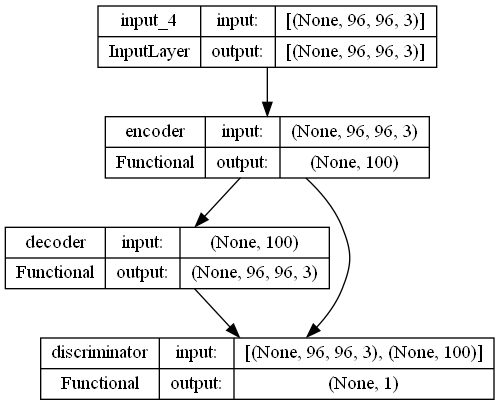

In [26]:
generator, discriminator, gan_model, encoder = build_vaegan(input_shape, latent_dim=100)
dot_img_file = '/VAEGAN.png'
tf.keras.utils.plot_model(gan_model, to_file=dot_img_file, show_shapes=True)

In [27]:
# size of the latent space
latent_dim = 100
# train model
train(generator, discriminator, encoder, gan_model, train_ds, latent_dim, n_epochs=11, resume_training=0)

>1, 1/433, d=0.685, g=0.725
>1, 11/433, d=0.659, g=0.796
>1, 21/433, d=0.624, g=0.861
>1, 31/433, d=0.601, g=0.943
>1, 41/433, d=0.540, g=0.927
>1, 51/433, d=0.444, g=0.982
>1, 61/433, d=0.363, g=1.154
>1, 71/433, d=0.268, g=1.352
>1, 81/433, d=0.170, g=1.394
>1, 91/433, d=0.129, g=1.510
>1, 101/433, d=0.087, g=1.634
>1, 111/433, d=0.078, g=1.590
>1, 121/433, d=0.047, g=1.216
>1, 131/433, d=0.039, g=1.438
>1, 141/433, d=0.026, g=1.009
>1, 151/433, d=0.023, g=1.066
>1, 161/433, d=0.028, g=0.976
>1, 171/433, d=0.016, g=0.603
>1, 181/433, d=0.023, g=0.641
>1, 191/433, d=0.014, g=0.639
>1, 201/433, d=0.009, g=0.817
>1, 211/433, d=0.007, g=0.822
>1, 221/433, d=0.010, g=0.506
>1, 231/433, d=0.005, g=0.544
>1, 241/433, d=0.004, g=0.488
>1, 251/433, d=0.004, g=0.340
>1, 261/433, d=0.005, g=0.239
>1, 271/433, d=0.008, g=0.312
>1, 281/433, d=0.011, g=0.339
>1, 291/433, d=0.003, g=0.320
>1, 301/433, d=0.003, g=0.161
>1, 311/433, d=0.001, g=0.203
>1, 321/433, d=0.002, g=0.128
>1, 331/433, d=0.002,

KeyboardInterrupt: 

test

In [17]:
generator = tf.keras.models.load_model('cgenerator_model_64_e131.h5')
discriminator = tf.keras.models.load_model('cdiscriminator_model_64.h5')

In [492]:
X = generator.predict([generate_latent_points(100, 1), types_to_vector('Ghost', 'Fighting')], verbose=0)
plot_image(X[0], "image générée", {"real": discriminator.predict([X, types_to_vector('Ghost', 'Fighting')], verbose=0)[0][0]}, 96)

In [ ]:
X = generator.predict([generate_latent_points(100, 1), np.array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])], verbose=0)
plot_image(X[0], "image générée", {"real": discriminator.predict([X, np.array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])], verbose=0)[0][0]}, 96)

In [91]:
# test image with random noise between -1 and 1
test_image_noise = tf.random.uniform(shape=(1, 96, 96, 3), minval=-1, maxval=1)

In [94]:
plot_image(test_image_noise[0], "image test", {"real": discriminator.predict([test_image_noise, types_to_vector('Dark')], verbose=0)[0][0]}, 96)

In [84]:
# load images/test/charmander.png to test
test_image = tf.keras.preprocessing.image.load_img('images/test/charmander.png', color_mode='rgba', target_size=image_size)
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = tf.expand_dims(test_image, axis=0)
test_image = preprocess_image(test_image)
print(test_image.shape)

(1, 96, 96, 3)


In [192]:
# test discriminator with test image
plot_image(test_image[0], "image test", {"real": discriminator.predict([test_image, types_to_vector('Fire', 'Flying')], verbose=0)[0][0]}, 96)